In [1]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    classification_report,
    f1_score,
    plot_confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
)
from tensorflow import keras

from tensorflow.keras.applications.efficientnet import EfficientNetB4, EfficientNetB7
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm

In [2]:
PATH = "/app/_data/"
BATCH_SIZE = 32
SEED = 1488
IMAGE_SIZE = (380, 380)
NUM_CLASSES = 6
INPUT_SHAPE = (380, 380, 3)
TRAIN_IMG_PATH = "/app/_data/train_images/"
TEST_IMG_PATH = "/app/_data/test_images/"
# MODEL_PATH = '/app/_data/models/effnet7_2_6cl_frozen_40ep_42.h5'

In [3]:
labels = pd.read_csv(PATH + "train_labels.csv")

In [4]:
sample_submission = pd.read_csv(PATH + "sample_submission.csv")

In [5]:
labels = labels.join(labels["labels"].str.get_dummies(sep=" "))

In [6]:
labels.head(1)

image   labels  complex  frog_eye_leaf_spot  healthy  \
0  800113bb65efe69e.jpg  healthy        0                   0        1   

   powdery_mildew  rust  scab  
0               0     0     0

In [7]:
feature_columns = labels.columns[2:].tolist()
feature_columns

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [8]:
feature_columns

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

### StratifiedKFold

In [9]:
def pred_to_labels(pred, thresh=0.5, labels=feature_columns):

    pred = [labels[i] for i in range(len(labels)) if pred[i] > thresh]
    pred = ' '.join(pred)
    return pred

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal_and_vertical", seed=SEED
        ),
        keras.layers.experimental.preprocessing.RandomRotation(0.15, seed=SEED),
        keras.layers.experimental.preprocessing.RandomZoom(0.25, 0.25, seed=SEED),
        keras.layers.experimental.preprocessing.RandomContrast(factor=0.05, seed=SEED),
        keras.layers.experimental.preprocessing.RandomTranslation(
            height_factor=0.2, width_factor=0.2, seed=SEED
        ),
    ]
)

In [11]:
# def write_np(file_path):
#     img = tf.io.read_file(TRAIN_IMG_PATH + file_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = tf.image.resize(
#         img,
#         IMAGE_SIZE,
#     )
#     img = tf.image.convert_image_dtype(img, tf.uint8)
#     img = Image.fromarray(np.array(img))
#     img.save(PATH + '380/'+file_path)
#     return img
#     np.save(PATH + 'cache/'+file_path[:-4], img)
# labels['image'].apply(write_np)

In [12]:
# from 380 uint8
def parse_image2(file_path):
    img = tf.io.read_file(PATH+'380/'+file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [13]:
# v1 from orig
def parse_image(file_path):
    img = tf.io.read_file(TRAIN_IMG_PATH+file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(
        img,
        IMAGE_SIZE,
    )
    img = tf.image.convert_image_dtype(img, tf.uint8)
    return img


In [14]:
def prepare_dataset(df, augmentation=False):
    dataset = tf.data.Dataset.from_tensor_slices(
        (df["image"].values, df[feature_columns].astype('uint8').values)
    )
    dataset = dataset.map(lambda x, y: (parse_image2(x), y))
    dataset = dataset.batch(BATCH_SIZE)

    if augmentation:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )
    dataset = dataset.repeat().prefetch(buffer_size=AUTOTUNE)
    return dataset

In [16]:
# ds_train = prepare_dataset(train, augmentation = True)
# ds_valid = prepare_dataset(valid)

In [17]:
def parse_test_image(img_name):
    img = tf.io.read_file(img_name)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(
        img,
        IMAGE_SIZE,
    )
    img = tf.image.convert_image_dtype(img, tf.uint8)
    return img


def predict_new(path, model):
    img = parse_test_image(path)
    img = tf.expand_dims(img,axis = 0)
    pred = model.predict(img)
    return pred_to_labels(pred[0])

In [18]:
policy = keras.mixed_precision.experimental.Policy('mixed_float16')
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro RTX 5000, compute capability 7.5


In [19]:
def scheduler(epoch, lr):
    if epoch < 5:
        return 0.01
    elif 5 <= epoch <10:
        return 0.001
    elif 10 <= epoch <50:
        return 0.0005
    else:
        return 0.0001

In [20]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True, verbose=0, mode='min',
    ),
    keras.callbacks.LearningRateScheduler(schedule = scheduler, verbose=1)
]

In [21]:
inputs = keras.Input(shape=INPUT_SHAPE)
base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
base_model.load_weights('/app/_data/models/efficientnet-b4_noisy-student_notop.h5', by_name=True, skip_mismatch = True)
x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Flatten(name="flatten")(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
effnet = keras.Model(inputs=inputs, outputs=outputs)


In [22]:
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
X = labels["image"]
y = labels[feature_columns]
for i, (train_index, valid_index) in enumerate(skf.split(labels["image"], labels['labels'])):
    train, valid = labels.loc[train_index], labels.loc[valid_index]
    model_name = 'eff4_ns_kf_' + str(i+1) + '.h5'
    ds_train = prepare_dataset(train, augmentation = True)
    ds_valid = prepare_dataset(valid)
    model = effnet
    model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(),
    metrics=['acc',
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="micro"),
    ],
)
    history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
    steps_per_epoch=(train.shape[0]*0.8)//BATCH_SIZE, 
    validation_steps= (valid.shape[0]*0.2)//BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    callbacks = callbacks
)
    model.save("/app/_data/models/"+model_name)
    


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
370/370 [==============================] - 249s 672ms/step - loss: 0.3142 - acc: 0.5971 - recall: 0.4693 - precision: 0.7016 - f1_score: 0.6036 - val_loss: 1.4795 - val_acc: 0.3872 - val_recall: 0.3552 - val_precision: 0.4803 - val_f1_score: 0.3969

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
370/370 [==============================] - 242s 653ms/step - loss: 0.2151 - acc: 0.7622 - recall: 0.6870 - precision: 0.8101 - f1_score: 0.7580 - val_loss: 0.9288 - val_acc: 0.5122 - val_recall: 0.5601 - val_precision: 0.5236 - val_f1_score: 0.5548

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
370/370 [==============================] - 241s 651ms/step - loss: 0.1910 - acc: 0.7878 - recall: 0.7300 - precision: 0.8317 - f1_score: 0.7842 - val_loss: 0.2776 - val_acc: 0.6739 - val_recall: 0.6700 - val_precision: 0.7152 - val_f1_score: 0.6785

Epoch 00004:

In [23]:
def plot_curves(model, loss=False):
    df = pd.DataFrame(model.history)
    if loss:
        plt.figure(figsize=(12, 6))
        plt.title("loss")
        plt.plot(df.iloc[:, 0], label="loss")
        plt.plot(df.iloc[:, 5], label="val_loss")
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(12, 20))
        plt.subplot(4, 1, 1)
        plt.title("accuracy")
        plt.plot(df.iloc[:, 1], label="accuracy")
        plt.plot(df.iloc[:, 6], label="val_accuracy")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.title("recall")
        plt.plot(df.iloc[:, 2], label="recall")
        plt.plot(df.iloc[:, 7], label="val_recall")
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.title("precision")
        plt.plot(df.iloc[:, 3], label="precision")
        plt.plot(df.iloc[:, 8], label="val_precision")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.title("f1")
        plt.plot(df.iloc[:, 4], label="f1")
        plt.plot(df.iloc[:, 9], label="val_f1")
        plt.legend()
        plt.show();

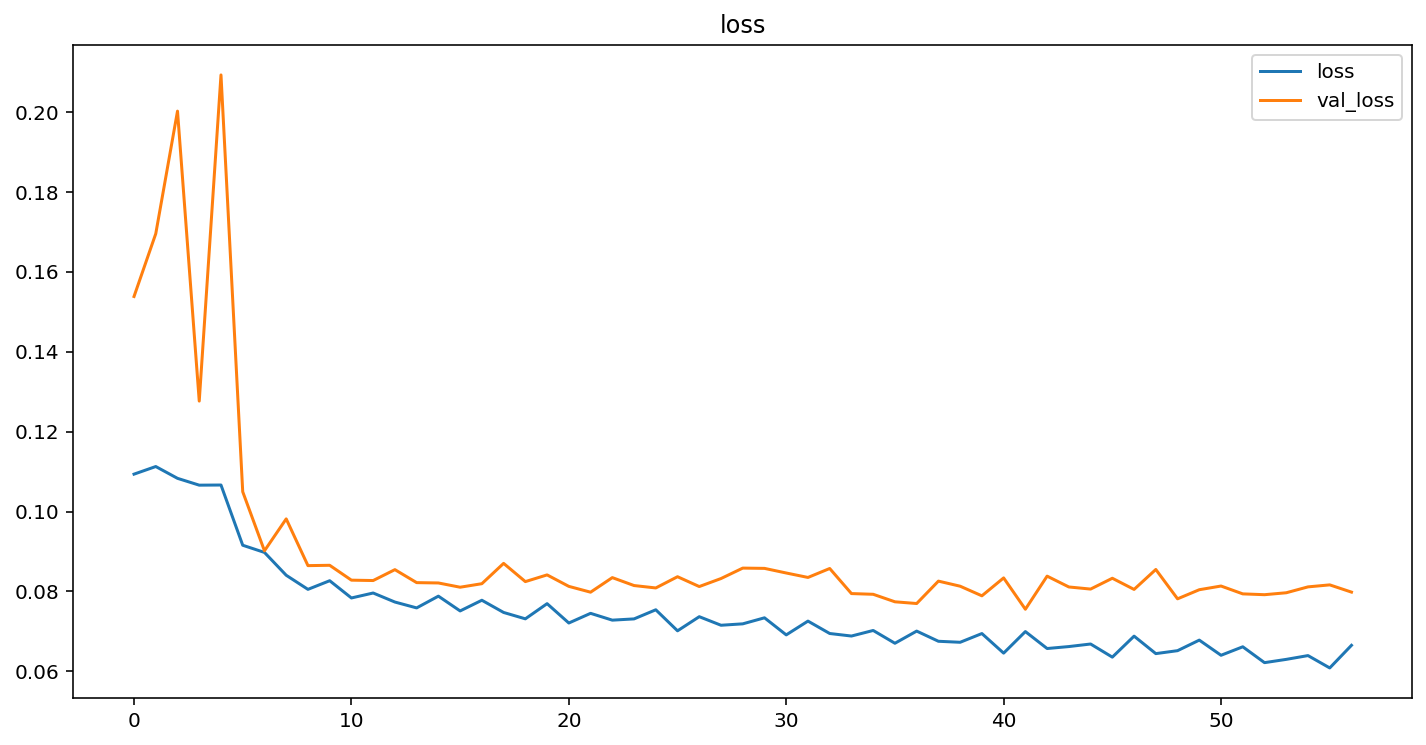

In [24]:
plot_curves(history,loss=True)

In [46]:
model = keras.models.load_model('/app/_data/models/eff4_ns_kf_1.h5')

In [47]:
def parse_all(file_path):
    img = tf.io.read_file(PATH+'380/'+file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img
def predict_new(path, model):
    img = parse_all(path)
    img = tf.expand_dims(img,axis = 0)
    pred = model.predict(img)
    return pred_to_labels(pred[0])

In [48]:
df_sub = pd.DataFrame(columns=['image','labels'])
for img_name in os.listdir(PATH+'380/'):
    pred = predict_new(img_name, model)
    
    df_sub = df_sub.append( {'image': img_name, 'labels': pred}, ignore_index = True )
    
print(df_sub.head())

                  image              labels
0  bfc6d90f402f4c34.jpg             complex
1  9eb93fe282326266.jpg      powdery_mildew
2  f4cb3a8f41b413e4.jpg  frog_eye_leaf_spot
3  98322eab16bef2c1.jpg                rust
4  dad5d6250cae80b7.jpg             complex


In [49]:
df_sub = df_sub.merge(labels[['image', 'labels']], on='image', how='left', suffixes=('_pred', '_true'))

In [50]:
df_sub.to_csv('/app/sandbox/wrong_predictions/prediction_raw_8_5.csv')

In [64]:
model = keras.models.load_model('/app/_data/models/eff4_ns_kf_5.h5')

In [65]:
w5 = model.weights

In [68]:
all_w = w1+w2+w3+w4+w5

In [71]:
w1[0]

<tf.Variable 'normalization/mean:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>

In [69]:
all_w

[<tf.Variable 'normalization/mean:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'normalization/variance:0' shape=(3,) dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>,
 <tf.Variable 'normalization/count:0' shape=() dtype=int64, numpy=0>,
 <AutoCastVariable 'stem_conv/kernel:0' shape=(3, 3, 3, 48) dtype=float32 true_dtype=float32, numpy=
 array([[[[ 1.4486091e-04,  6.2481787e-02, -2.5702640e-01, ...,
           -3.7330657e-01,  3.4959337e-01,  9.6612769e-01],
          [ 1.3097675e-04,  1.6274892e+00, -2.8590415e-02, ...,
            7.8305036e-01,  4.2070419e-01, -4.3445483e-01],
          [ 9.9513440e-05, -2.2379952e-02, -8.4122378e-01, ...,
           -5.5856037e-01,  3.2125226e-01, -6.2047404e-01]],
 
         [[ 1.4165492e-04,  1.8588880e-01, -3.2322735e-01, ...,
           -1.2392796e-01,  2.9086599e-01,  1.8069922e+00],
          [ 1.2476416e-04,  1.2825737e+00, -4.7904111e-02, ...,
           -5.8161516e-02,  2.4642663e-01, -4.5915

In [ ]:
df_sub = pd.DataFrame(columns=['image','labels'])
for img_name in os.listdir(TEST_IMG_PATH):
    pred = predict_new(TEST_IMG_PATH+img_name, model)
    
    df_sub = df_sub.append( {'image': img_name, 'labels': pred}, ignore_index = True )
    
print(df_sub.head())
df_sub.to_csv('submission.csv', index=False)
print('Submission completed')